In [ ]:
#pip install pandas numpy scikit-learn torch tab-transformer-pytorch matplotlib seaborn shap


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

import torch
from tab_transformer_pytorch import TabTransformer

import gradio as gr

device = "cuda" if torch.cuda.is_available() else "cpu"

<h3>Load master dataset</h3>

In [3]:
df = pd.read_csv(r"C:\Users\ansh1\OneDrive\Desktop\UA\anshul.csv")
print("Dataset shape:", df.shape)
df.head()

Dataset shape: (8099, 35)


,company_id,flight_number,scheduled_departure_date_local,scheduled_departure_station_code,scheduled_arrival_station_code,scheduled_departure_datetime_local,scheduled_arrival_datetime_local,actual_departure_datetime_local,actual_arrival_datetime_local,total_seats,...,high_load,delay_norm,ssr_norm,bag_ratio_norm,load_norm,tight_flag,high_load_flag,difficulty_score,daily_rank,difficulty_cat
0,OO,4792,2025-08-04,ORD,ROA,2025-08-04T17:57:00Z,2025-08-04T21:04:00Z,2025-08-04T18:04:00Z,2025-08-04T20:52:00Z,76,...,False,0.023211,0.000000,0.057143,0.117647,0,0,0.041921,474.0,Easy
1,UA,920,2025-08-03,ORD,LHR,2025-08-03T18:05:00Z,2025-08-04T08:20:00Z,2025-08-03T18:27:00Z,2025-08-04T08:06:00Z,167,...,False,0.037718,0.111111,0.105714,0.318786,0,0,0.118437,157.0,Medium
2,UA,1776,2025-08-10,ORD,PHL,2025-08-10T18:20:00Z,2025-08-10T21:35:00Z,2025-08-10T20:11:00Z,2025-08-10T23:26:00Z,166,...,False,0.123791,0.111111,0.108571,0.335863,0,0,0.148247,91.0,Difficult
3,OO,5790,2025-08-06,ORD,CRW,2025-08-06T18:20:00Z,2025-08-06T21:04:00Z,2025-08-06T20:05:00Z,2025-08-06T22:42:00Z,50,...,False,0.117988,0.000000,0.114286,0.098672,0,0,0.077988,265.0,Medium
4,UA,1398,2025-08-05,ORD,ATL,2025-08-05T18:20:00Z,2025-08-05T21:29:00Z,2025-08-05T18:16:00Z,2025-08-05T21:49:00Z,166,...,False,0.012573,0.000000,0.145714,0.252372,0,0,0.083389,263.0,Medium


<h3>Exploratory Data Analysis (EDA)</h3>

Average delay: 21.18 minutes
Percentage of flights departing late: 49.61%
Flights with tight ground time: 652 / 8099
Average transfer/checked bag ratio: 38.18


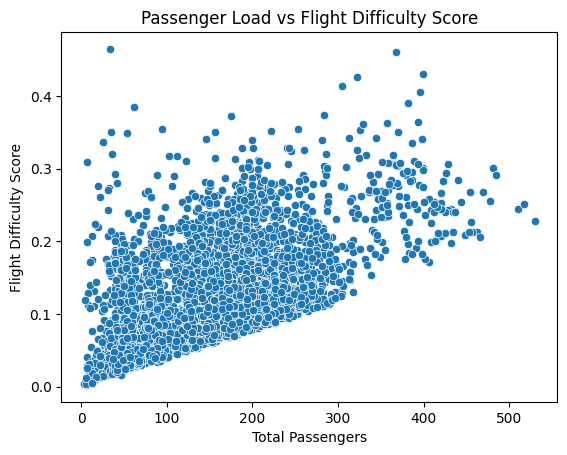

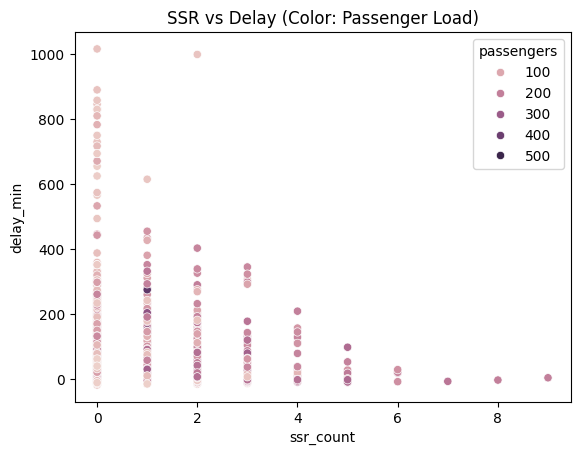

In [4]:
# Average delay & % of flights departing late
avg_delay = df['delay_min'].mean()
percent_late = (df['delay_min'] > 0).mean() * 100
print(f"Average delay: {avg_delay:.2f} minutes")
print(f"Percentage of flights departing late: {percent_late:.2f}%")

# Flights with tight ground time
tight_ground_flights = df['tight_ground'].sum()
print(f"Flights with tight ground time: {tight_ground_flights} / {len(df)}")

# Average transfer-to-checked bag ratio
avg_transfer_ratio = df['transfer_ratio'].mean()
print(f"Average transfer/checked bag ratio: {avg_transfer_ratio:.2f}")

# Passenger load vs operational difficulty
sns.scatterplot(x='passengers', y='difficulty_score', data=df)
plt.title("Passenger Load vs Flight Difficulty Score")
plt.xlabel("Total Passengers")
plt.ylabel("Flight Difficulty Score")
plt.show()

# SSR vs Delay controlling for load
sns.scatterplot(x='ssr_count', y='delay_min', hue='passengers', data=df)
plt.title("SSR vs Delay (Color: Passenger Load)")
plt.show()

<h3>Flight Difficulty Score Development</h3>

In [5]:
# Rank flights by difficulty per day
df['daily_rank'] = df.groupby('scheduled_departure_date_local')['difficulty_score'] \
                     .rank(method='first', ascending=False)

# Classification into Difficult / Medium / Easy
def classify_rank(group):
    n = len(group)
    difficult = int(n * 0.33)
    medium = int(n * 0.33)
    easy = n - (difficult + medium)
    categories = ['Difficult']*difficult + ['Medium']*medium + ['Easy']*easy
    group = group.sort_values('daily_rank', ascending=True)
    group['difficulty_cat'] = categories
    return group

df = df.groupby('scheduled_departure_date_local').apply(classify_rank)
df.head()


C:\Users\ansh1\AppData\Local\Temp\ipykernel_15328\127153803.py:16: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby('scheduled_departure_date_local').apply(classify_rank)


company_id  flight_number  \
scheduled_departure_date_local                                  
2025-08-01                     6984         UA            972   
                               6578         UA           1811   
                               1842         UA           1363   
                               2925         UA           2182   
                               1680         UA           2207   

                                    scheduled_departure_date_local  \
scheduled_departure_date_local                                       
2025-08-01                     6984                     2025-08-01   
                               6578                     2025-08-01   
                               1842                     2025-08-01   
                               2925                     2025-08-01   
                               1680                     2025-08-01   

                                    scheduled_departure_station_code  \
scheduled_departure_date_local                                         
2025-08-01                     6984                              ORD   
                               6578                              ORD   
                               1842                              ORD   
                               2925                              ORD   
                               1680                              ORD   

                                    scheduled_arrival_station_code  \
scheduled_departure_date_local                                       
2025-08-01                     6984                            BRU   
                               6578                            MSP   
                               1842                            LAX   
                               2925                            PHL   
                               1680                            OMA   

                                    scheduled_departure_datetime_local  \
scheduled_departure_date_local                                           
2025-08-01                     6984               2025-08-01T17:50:00Z   
                               6578               2025-08-01T12:45:00Z   
                               1842               2025-08-01T12:54:00Z   
                               2925               2025-08-01T11:20:00Z   
                               1680               2025-08-01T15:58:00Z   

                                    scheduled_arrival_datetime_local  \
scheduled_departure_date_local                                         
2025-08-01                     6984             2025-08-02T08:50:00Z   
                               6578             2025-08-01T14:28:00Z   
                               1842             2025-08-01T15:23:00Z   
                               2925             2025-08-01T14:29:00Z   
                               1680             2025-08-01T17:36:00Z   

                                    actual_departure_datetime_local  \
scheduled_departure_date_local                                        
2025-08-01                     6984            2025-08-01T20:23:00Z   
                               6578            2025-08-01T13:39:00Z   
                               1842            2025-08-01T13:16:00Z   
                               2925            2025-08-01T11:42:00Z   
                               1680            2025-08-01T16:27:00Z   

                                    actual_arrival_datetime_local  \
scheduled_departure_date_local                                      
2025-08-01                     6984          2025-08-02T10:50:00Z   
                               6578          2025-08-01T15:01:00Z   
                               1842          2025-08-01T15:51:00Z   
                               2925          2025-08-01T14:36:00Z   
                               1680          2025-08-01T17:48:00Z   

                                     total_seats  ... high_load delay_norm  \
scheduled

<h3>Post-Analysis & Operational Insights</h3>

Top 10 destinations by difficulty:
 scheduled_arrival_station_code
BRU    0.346316
GRU    0.291204
HND    0.286471
FRA    0.265952
HNL    0.257367
ATH    0.232628
NAS    0.222558
AUA    0.216641
DUB    0.209229
CDG    0.193780
Name: difficulty_score, dtype: float64


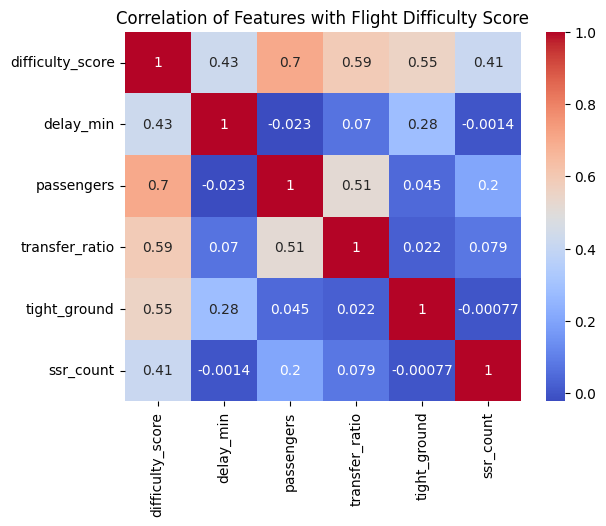

In [6]:
# 1. Top destinations by difficulty
dest_difficulty = df.groupby('scheduled_arrival_station_code')['difficulty_score'].mean().sort_values(ascending=False)
print("Top 10 destinations by difficulty:\n", dest_difficulty.head(10))

# 2. Correlation heatmap (drivers)
corr = df[['difficulty_score', 'delay_min', 'passengers', 
           'transfer_ratio', 'tight_ground', 'ssr_count']].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title("Correlation of Features with Flight Difficulty Score")
plt.show()

<h3>Features</h3>

In [7]:
# Continuous features
cont_features = ['delay_min', 'passengers', 'transfer_ratio', 'tight_ground', 'ssr_count']

# Categorical features 
cat_features = ['scheduled_departure_station_code', 'scheduled_arrival_station_code', 'fleet_type', 'carrier']

# Target
target = 'difficulty_score'


<h3>Encode categorical features</h3>

In [8]:
encoders = {}
for col in cat_features:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    encoders[col] = le


In [9]:
X_cat = df[cat_features].values.astype(np.int64)
X_cont = df[cont_features].values.astype(np.float32)
y = df[target].values.astype(np.float32)

# Train-test split
X_cat_train, X_cat_test, X_cont_train, X_cont_test, y_train, y_test = train_test_split(
    X_cat, X_cont, y, test_size=0.2, random_state=42
)

# Convert to torch tensors
X_cat_train = torch.tensor(X_cat_train, dtype=torch.long).to(device)
X_cat_test = torch.tensor(X_cat_test, dtype=torch.long).to(device)
X_cont_train = torch.tensor(X_cont_train, dtype=torch.float32).to(device)
X_cont_test = torch.tensor(X_cont_test, dtype=torch.float32).to(device)
y_train = torch.tensor(y_train, dtype=torch.float32).view(-1,1).to(device)
y_test = torch.tensor(y_test, dtype=torch.float32).view(-1,1).to(device)


<h3>Prepare data</h3>

In [10]:
categories = [len(np.unique(df[col])) for col in cat_features]

model = TabTransformer(
    categories=categories,
    num_continuous=len(cont_features),
    dim=64,
    depth=4,
    heads=8,
    attn_dropout=0.1,
    ff_dropout=0.1,
    mlp_hidden_mults=(4,2)
).to(device)

criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)


<h3>Build TabTransformer model</h3>

In [11]:

epochs = 50
batch_size = 64
n_samples = X_cont_train.shape[0]

for epoch in range(epochs):
    permutation = torch.randperm(n_samples)
    epoch_loss = 0

    for i in range(0, n_samples, batch_size):
        indices = permutation[i:i+batch_size]
        x_cat_batch = X_cat_train[indices]
        x_cont_batch = X_cont_train[indices]
        y_batch = y_train[indices]

        optimizer.zero_grad()
        output = model(x_categ=x_cat_batch, x_cont=x_cont_batch)
        loss = criterion(output, y_batch)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item() * len(y_batch)

    print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss/n_samples:.4f}")


Epoch 1/50, Loss: 0.6295
Epoch 2/50, Loss: 0.0020
Epoch 3/50, Loss: 0.0019
Epoch 4/50, Loss: 0.0018
Epoch 5/50, Loss: 0.0016
Epoch 6/50, Loss: 0.0016
Epoch 7/50, Loss: 0.0015
Epoch 8/50, Loss: 0.0014
Epoch 9/50, Loss: 0.0014
Epoch 10/50, Loss: 0.0014
Epoch 11/50, Loss: 0.0014
Epoch 12/50, Loss: 0.0014
Epoch 13/50, Loss: 0.0013
Epoch 14/50, Loss: 0.0013
Epoch 15/50, Loss: 0.0013
Epoch 16/50, Loss: 0.0013
Epoch 17/50, Loss: 0.0013
Epoch 18/50, Loss: 0.0013
Epoch 19/50, Loss: 0.0013
Epoch 20/50, Loss: 0.0013
Epoch 21/50, Loss: 0.0013
Epoch 22/50, Loss: 0.0013
Epoch 23/50, Loss: 0.0013
Epoch 24/50, Loss: 0.0013
Epoch 25/50, Loss: 0.0013
Epoch 26/50, Loss: 0.0013
Epoch 27/50, Loss: 0.0012
Epoch 28/50, Loss: 0.0013
Epoch 29/50, Loss: 0.0012
Epoch 30/50, Loss: 0.0012
Epoch 31/50, Loss: 0.0012
Epoch 32/50, Loss: 0.0013
Epoch 33/50, Loss: 0.0012
Epoch 34/50, Loss: 0.0012
Epoch 35/50, Loss: 0.0012
Epoch 36/50, Loss: 0.0012
Epoch 37/50, Loss: 0.0012
Epoch 38/50, Loss: 0.0012
Epoch 39/50, Loss: 0.

<h3>Train model</h3>

In [12]:
model.eval()
with torch.no_grad():
    y_pred = model(x_categ=X_cat_test, x_cont=X_cont_test)
    mse = criterion(y_pred, y_test).item()
    print("Test MSE:", mse)

Test MSE: 0.0014876739587634802


<h3>Evaluate model</h3>

In [13]:

categorical_features = ['scheduled_departure_station_code', 'scheduled_arrival_station_code', 'fleet_type', 'carrier']
continuous_features = [col for col in df.columns if col not in categorical_features + ['Flight_Difficulty_Score']]



In [ ]:
#pip install gradio


<h3>UI</h3>

In [14]:
def predict_flight_difficulty(dep_airport, arr_airport, fleet_type, carrier,
                              delay, total_passengers, transfer_ratio, tight_ground_flag, ssr_count):
    # Categorical features
    cat_input = []
    inputs = [dep_airport, arr_airport, fleet_type, carrier]
    for i, col in enumerate(cat_features):
        le = encoders[col]
        val = inputs[i]
        if val in le.classes_:
            cat_input.append(le.transform([val])[0])
        else:
            cat_input.append(-1)
    cat_input = torch.tensor([cat_input], dtype=torch.long).to(device)
    
    cont_input = np.array([[delay, total_passengers, transfer_ratio, tight_ground_flag, ssr_count]], dtype=np.float32)
    cont_input = torch.tensor(cont_input, dtype=torch.float32).to(device)
    
    model.eval()
    with torch.no_grad():
        pred = model(x_categ=cat_input, x_cont=cont_input).item()
    
    pred = max(0, pred)
    return round(pred, 3)

ui = gr.Interface(
    fn=predict_flight_difficulty,
    inputs=[
        gr.Dropdown(choices=list(encoders['scheduled_departure_station_code'].classes_), label="Departure Airport Code"),
        gr.Dropdown(choices=list(encoders['scheduled_arrival_station_code'].classes_), label="Arrival Airport Code"),
        gr.Dropdown(choices=list(encoders['fleet_type'].classes_), label="Fleet Type"),
        gr.Dropdown(choices=list(encoders['carrier'].classes_), label="Carrier"),
        gr.Number(label="Delay (minutes)", value=0),
        gr.Number(label="Total Passengers", value=0),
        gr.Number(label="Transfer to Checked Ratio", value=0.0),
        gr.Number(label="Tight Ground Time Flag (0 or 1)", value=0),
        gr.Number(label="SSR Count", value=0)
    ],
    outputs=gr.Textbox(label="Predicted Flight Difficulty Score")
)

ui.launch()

* Running on local URL:  http://127.0.0.1:7860
* To create a public link, set `share=True` in `launch()`.
